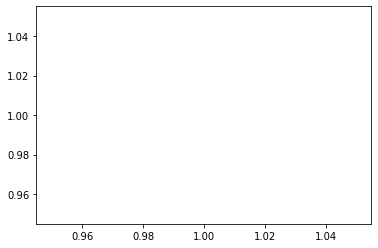

In [1]:
import matplotlib.pyplot as plt

plt.plot([1], [1])

In [2]:
## Relocate to the main level of the repository

import os

In [3]:
if 'whole_pipeline.ipynb' in os.listdir():
    os.chdir('..')

In [4]:
## Imports

from pipeline import data_to_dataframe_with_features, dataframe_to_dataset, split_dataset, make_model, make_fitting_related_objects, fit_the_model
from pipeline import pipeline_predict

In [5]:
## Raw data

# In this cell, please load your questions and labels as you choose.
# Then place them in the Questions and Labels lists below.
# We filled these two lists with ten dummy questions so that the rest of the notebook can be run.

Questions = [
    'Quand est mort Napoléon?',
    'Où se trouve la Tour Eiffel?',
    'Quelle est la plus belle ville du monde?',
    'Pourquoi est-ce que le poulet a traversé la route?',
    'Qui a découvert l\'arche d\'alliance dans Indina Jones et les aventuriers de l\'arche perdue?',
    'Comment a-t-il fait?',
    'Combien de kilos dans un litre?',
    'Qui a écrit Le petit Prince?',
]

Labels = [1, 1, 0, 0, 1, 0, 0, 1,]


In [6]:
## Explanations

# In the following cells, you will find each step of the pipeline.
# At every step, there is only one function being run, with all its arguments shown.
# Before each function, we added its docstring.
# Most arguments have a default value, but those necessary are followed by the #- NECESSARY -# tag

In [7]:
## Convert the data to a dataframe with features

"""
Turns a list of (questions) and their (labels) into a dataframe with lexical-based features extracted from the questions.
The quantity of features extracted depends on the (restricted) flag.
For non-literary or short texts, it is recommended to set (restricted) as True.
"""

Dataframe = data_to_dataframe_with_features(
    questions=Questions, #- NECESSARY -#
    labels=Labels,       #- NECESSARY -#
    restricted=True,
)

C:\Users\meri2\.conda\envs\rorch\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'fr_core_news_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\meri2\.conda\envs\rorch\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\meri2\.conda\envs\rorch\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\meri2\.conda\envs\rorch\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\meri2\

In [8]:
## Convert the dataframe to a dataset

"""
Converts a (dataframe_with_features) to a FeatureDataset for fitting a model.
The columns containing questions and labels are identified with (question_column) and (label_column).
The dataset is normalized if the (normalize) flag is set to True, ignoring nans. This is strongly recommended.
The nans are replaced with (na_replace_value) to avoid errors during training, -1.0 by default.
"""

Dataset = dataframe_to_dataset(
    dataframe_with_features=Dataframe, #- NECESSARY -#
    question_column='question',
    label_column='label',
    normalize=True,
    na_replace_value=-1.0,
)

In [9]:
## Split the dataset to training and validation sets

"""
Splits the (dataset) according to the proportion (p). Training size is int(p * len(dataset)). By default, p = 0.6.
The training set is balanced if (balance_train) is set to True. Same goes for validation set and (balance_val).
    By default, training isn't balanced because weighting the loss function is enough, and validation is balanced to get relevant metrics.
For reproducibilty's sake, a (seed) can be passed, or left to None for real randomness.
"""

Train, Validation = split_dataset(
    dataset=Dataset, #- NECESSARY -#
    p=0.6,
    balance_train=False,
    balance_val=True,
    seed=42,
)

Length before balancing: 4
Length after balancing: 4


In [10]:
## Create the FeatureClassifier

"""
Generates a FeatureClassifier model with the given parameters.
The (training_dataset) is needed for two reasons: knowing the number of features and weighting the loss according to the dataset proportions.
If you want to disable loss weighting, set (use_weighted_loss) to False.
The hyperparameters are the (dropout_rate) and the (hidden_size), both set to the best value found by cross-training.
For reproducibilty's sake, a (seed) can be passed, or left to None for real randomness.
The model is switched to cuda unless (cuda) is set to False.
"""

Model = make_model(
    training_dataset=Train, #- NECESSARY -#
    dropout_rate=0.4,
    hidden_size=200,
    seed=42,
    use_weighted_loss=True,
    cuda=True,
)

In [13]:
## Create the optimizer, the logger and the callbacks

"""
Generates the objects needed for the model fitting, namely an AdamW optimizer, a Logger and Callbacks.
The (model) is needed for the optimizer to know what to optimize.
The optimizer is an AdamW with (learning_rate) set to 4e-5 by default, value found by cross-training.
The (metrics) list tells the Logger what to monitor, by default training and validation loss and accuracy.
The (early_stopping_patience) can be left to 0 if you don't want early stopping. If you do, set it to an integer >= 1. 
If early stopping is on, you can also choose:
    - the number of warmup epochs with (early_stopping_warmup).
    - the metric used with (early_stopping_metric), the metric used needs to be in the logger, so pass it with (metrics).
    - whether or not to (restore_best_weight) found during training in regards to (early_stopping_metric)
    - if (restore_best_weight) is on, please provide a (best_weights_savepath) in which the model and optimizer will be saved
"""

Fitting_related_objects = make_fitting_related_objects(
    model=Model, #- NECESSARY -#
    learning_rate=4e-5,
    metrics=None, # Will be replaced by ['train loss', 'train acc', 'val loss', 'val acc'] if left as None
    early_stopping_patience=500,
    early_stopping_warmup=100,
    early_stopping_metric='Validation Accuracy',
    restore_best_weights=True,
    best_weights_savepath='',
)

Best Training Loss: 0.31328028440475464
Best Training Accuracy: 1.0
Best Validation Loss: 0.434060275554657
Best Validation Accuracy: 0.75



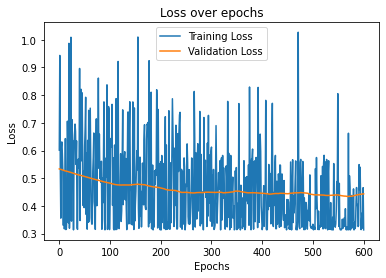

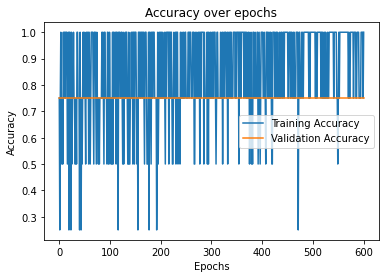

In [14]:
## Training

"""
Fits the (model) on the (training_and_validation_datasets) with the (fitting_related_objects).
The (training_and_validation_datasets) is a tuple of two FeatureDataset, like the one returned by split_dataset.
The (fitting_related_objects) is a tuple of an AdamW, a logger and callbacks, like the one returned by make_fitting_related_objects.
The fittings lasts for (number_of_epochs) with a given (batch_size), by default 256, best value found with cross training.
For reproducibilty's sake, a (seed) can be passed, or left to None for real randomness.
"""

fit_the_model(
    model=Model,                                          #- NECESSARY -#
    fitting_related_objects=Fitting_related_objects,      #- NECESSARY -#
    training_and_validation_datasets=(Train, Validation), #- NECESSARY -#
    number_of_epochs=10000,
    batch_size=256,
    seed=42,
)

In [16]:
## Eventual save

# ------------------------------------------------------------------------------------------------------------------------
#
# At this point, if you want to save the model you trained, uncomment the code below, change the Savepath and run the cell
#
# ------------------------------------------------------------------------------------------------------------------------


# Savepath = 'model_save_location.pt'
# Model.save(Savepath)

In [17]:
## Loading the data on which you want to predict

# -------------------------------------------------------------------------
#
# At this point, if you want to run the model you trained on new questions,
# you can load them in Questions_on_which_to_predict and run the code below
#
# -------------------------------------------------------------------------

Questions_on_which_to_predict = ['Est-ce que ceci est une bonne question?']

In [19]:
## Prediction

"""
Standardized pipeline for prediction of the quality of a list of (questions).
The model used for prediction can be passed directly or pointed to, both with the (model_or_path) argument.
The (batch_size) for predictions shouldn't be a problem, as the model is fast and lightweight.
"""

Predictions = pipeline_predict(
    questions=Questions_on_which_to_predict, #- NECESSARY -#,
    model_or_path=Model,                     #- NECESSARY -#
    batch_size=64,
)

Predictions

100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


[0]